## Imports

In [52]:
# general imports 
import numpy as np
import pandas as pd
from convokit import Corpus, download
import matplotlib.pyplot as plt

# imports specific to lexical measures
import re
from wordfreq import zipf_frequency
from lexical_diversity import lex_div as ld
from collections import Counter

In [81]:
# import data processing functions
import sys
import os

# add parent directory to Python path
sys.path.append(os.path.abspath(".."))
from src import corpus_to_df, lexical_preprocessing_df

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [33]:
corpus = Corpus(filename=download("subreddit-Cornell"))

Dataset already exists at /Users/nickvick/.convokit/saved-corpora/subreddit-Cornell


## Lexical Analysis Functions

In [34]:
def mtld_score(clean_tokens):
    '''Function that returns the MTLD score for a given set of cleaned, lemmatized tokens.
    A higher MTLD score indicates higher lexical diversity.'''

    # compute mtld
    mtld_score = ld.mtld(clean_tokens)

    return mtld_score

In [35]:
def yules_K(clean_tokens):
    '''Function that returns Yule's characteristic constant K for a given set of 
    cleaned, lemmatized tokens. A lower Yule's K indicates higher lexical diversity.'''

    N = len (clean_tokens)
    if N == 0:
        return 0.0
    
    # count how many times each word occurs
    freq_counts = Counter(clean_tokens)

    # create V_i
    V = Counter(freq_counts.values()) # keys are frequencies, values are counts of types

    # compute sum of i^2 * V_i
    sum_isq_vi = sum((i**2) * Vi for i, Vi in V.items())

    # apply Yule's formula
    K = 10000 * ((sum_isq_vi - N)/(N**2))

    return K

In [36]:
def zipf_score(clean_tokens):
    '''Returns the average frequency score (higher -> more frequent) based on the Zipf scale
    for a given set of cleaned, lemmatized tokens. A higher Zipf score corresponds to higher
    lexical diversity.'''
    
    # compute Zipf parameter Z for each word
    zipf_values = [zipf_frequency(word, 'en') for word in clean_tokens]

     # if there are no words, return a default value
    if len(zipf_values) == 0:
        return np.nan

    # find the average zipf parameter
    zipf_score = np.mean(zipf_values)

    return zipf_score

In [37]:
# build aoa_dict: word -> average age of acquisition
aoa_df = pd.read_csv("../Data/KupermanAoAData.csv")
aoa_dict = dict(zip(aoa_df["word"], aoa_df["rating_mean"]))

def aoa_score(clean_tokens, aoa_dict=aoa_dict):
    '''Returns the average age of acquisition score for a set of cleaned, lemmatized tokens.
    A higher mean AoA score indicates higher lexical difficulty.'''
    
    # extract aoa value only if the word is in the AoA dict
    aoa_values = [aoa_dict[word] for word in clean_tokens if word in aoa_dict]

    # if there are no words, return a default value
    if len(aoa_values) == 0:
        return np.nan
    
    # average the aoa values across all words
    aoa_score = np.mean(aoa_values)

    return aoa_score

In [58]:
# import NAWL list of academic words
nawl_list = pd.read_csv("../Data/nawl_cleaned.csv")

def nawl_ratio(clean_tokens, nawl_list=nawl_list):
    '''Returns the ratio of words present in the NAWL given a set of cleaned, lemmatized tokens.
    A higher NAWL ratio indicates higher academic lexical sophistication.'''

    # compute the total number of words
    total_num_words = len(clean_tokens)

    # if there are no tokens, return null value
    if total_num_words == 0:
        return np.nan

    num_nawl_words = 0
    # compute the number of values in NAWL
    for word in clean_tokens:
        if word in nawl_list:
            num_nawl_words += 1

    # compute the nawl ratio
    nawl_ratio = num_nawl_words / total_num_words

    return nawl_ratio

In [56]:
nawl_list.head()

,abdominal
0,abdominals
1,absorb
2,absorbs
3,absorbed
4,absorbing


## Data Analysis

In [83]:
# process the df
df = corpus_to_df(corpus)
df = lexical_preprocessing_df(df)

/Users/nickvick/Library/CloudStorage/OneDrive-PrincetonUniversity/ORFE/Thesis/ORFE-Thesis/src/data_preprocessing.py:306: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [84]:
# compute the relevant metrics for each utterance
def compute_lexical_vals(df):
    '''Function that applies all of the relevant lexical analysis functions to the cleaned tokens.'''

    print("Computing MTLD values...")
    df["mtld_score"] = df["final"].apply(mtld_score)

    print("Computing Yules K values...")
    df["yules_k"] = df["final"].apply(yules_K)

    print("Computing Zipf score values values...")
    df["zipf_score"] = df["final"].apply(zipf_score)

    print("Computing AOA score values...")
    df["aoa_score"] = df["final"].apply(aoa_score)

    print("Computing NAWL ratio values...")
    df["nawl_ratio"] = df["final"].apply(nawl_ratio)

In [85]:
compute_lexical_vals(df)

Computing MTLD values...
Computing Yules K values...
Computing Zipf score values values...
Computing AOA score values...
Computing NAWL ratio values...


In [86]:
df.set_index('timestamp', inplace=True)

In [88]:
df.head()

,utterance_id,speaker_id,text,final,mtld_score,yules_k,zipf_score,aoa_score,nawl_ratio
timestamp,,,,,,,,,
2012-01-01 16:18:18,nyx4d,reddmau5,I was just reading about the Princeton Mic-Che...,"[i, be, just, read, about, the, princeton, and...",95.573333,58.593750,6.074688,5.155714,0.0
2012-01-02 13:57:15,o0145,shtylman,I have added support for Cornell to courseoff....,"[i, have, add, support, for, cornell, to, cour...",91.873600,103.852192,5.968571,5.383294,0.0
2012-01-03 14:55:06,o1gca,moon_river,"i don't have a facebook, so we'd need a volunt...","[i, don't, have, a, facebook, so, we'd, need, ...",47.250000,158.024691,5.960889,4.856667,0.0
2012-01-03 01:16:17,o0ss4,moon_river,"so, i'm starting to mess with some of the css ...","[so, i'm, start, to, mess, with, some, of, the...",235.480000,23.781213,5.622069,4.769167,0.0
2012-01-05 17:08:06,o4ipd,reddmau5,Ever since SOPA put fear into the hearts of ev...,"[ever, since, sopa, put, fear, into, the, hear...",103.086667,108.646446,5.901915,5.558372,0.0


In [89]:
# aggregate metrics by month
numeric_cols = ['mtld_score', 'yules_k', 'zipf_score', 'aoa_score', 'nawl_ratio']
monthly_metrics = df[numeric_cols].resample('ME').mean()

## Visualizations

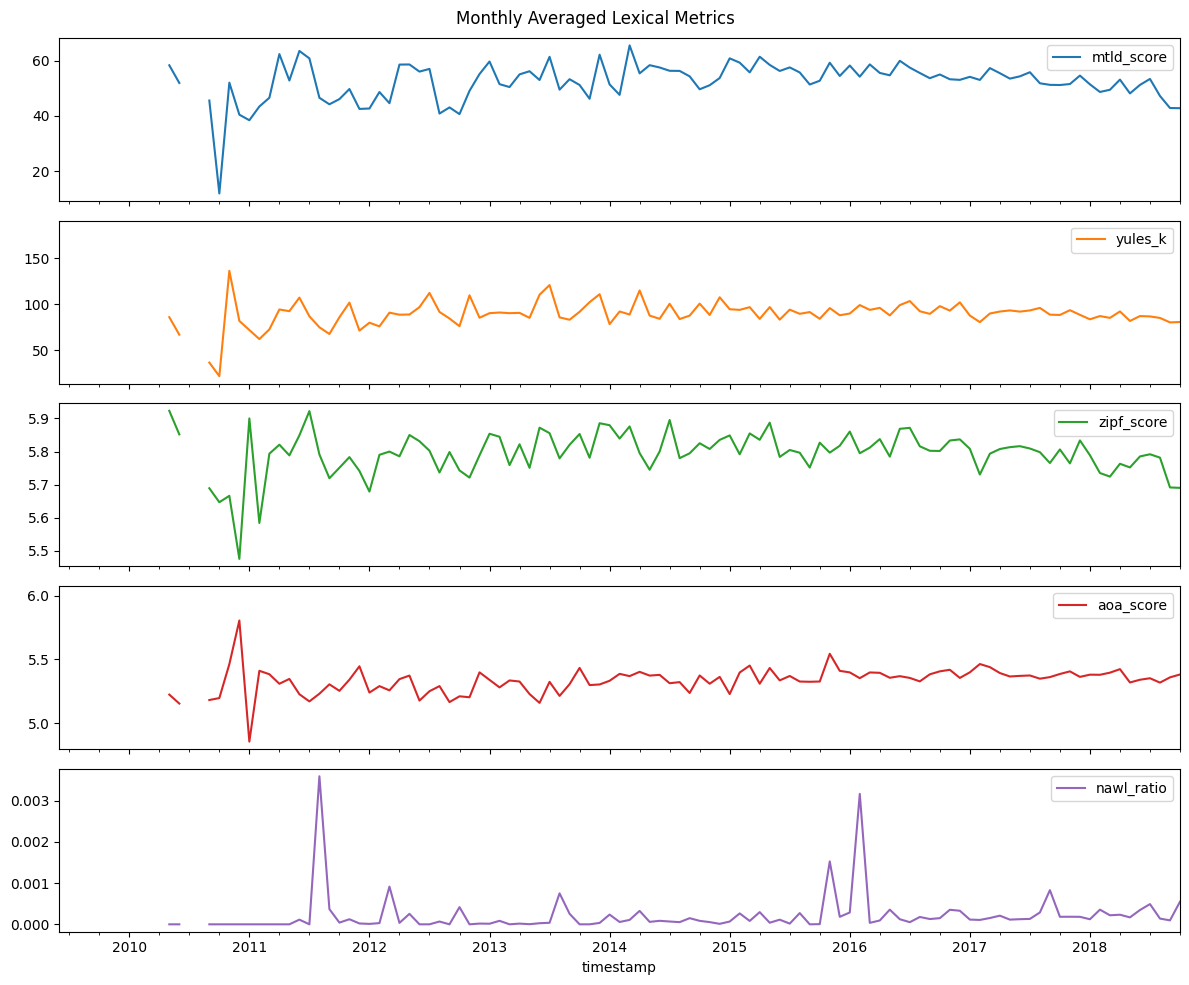

In [90]:
# plot monthly average metrics
monthly_metrics.plot(
    subplots=True,
    figsize=(12, 10),
    layout=(5, 1),
    title="Monthly Averaged Lexical Metrics",
    legend=True
)

plt.tight_layout()
plt.show()

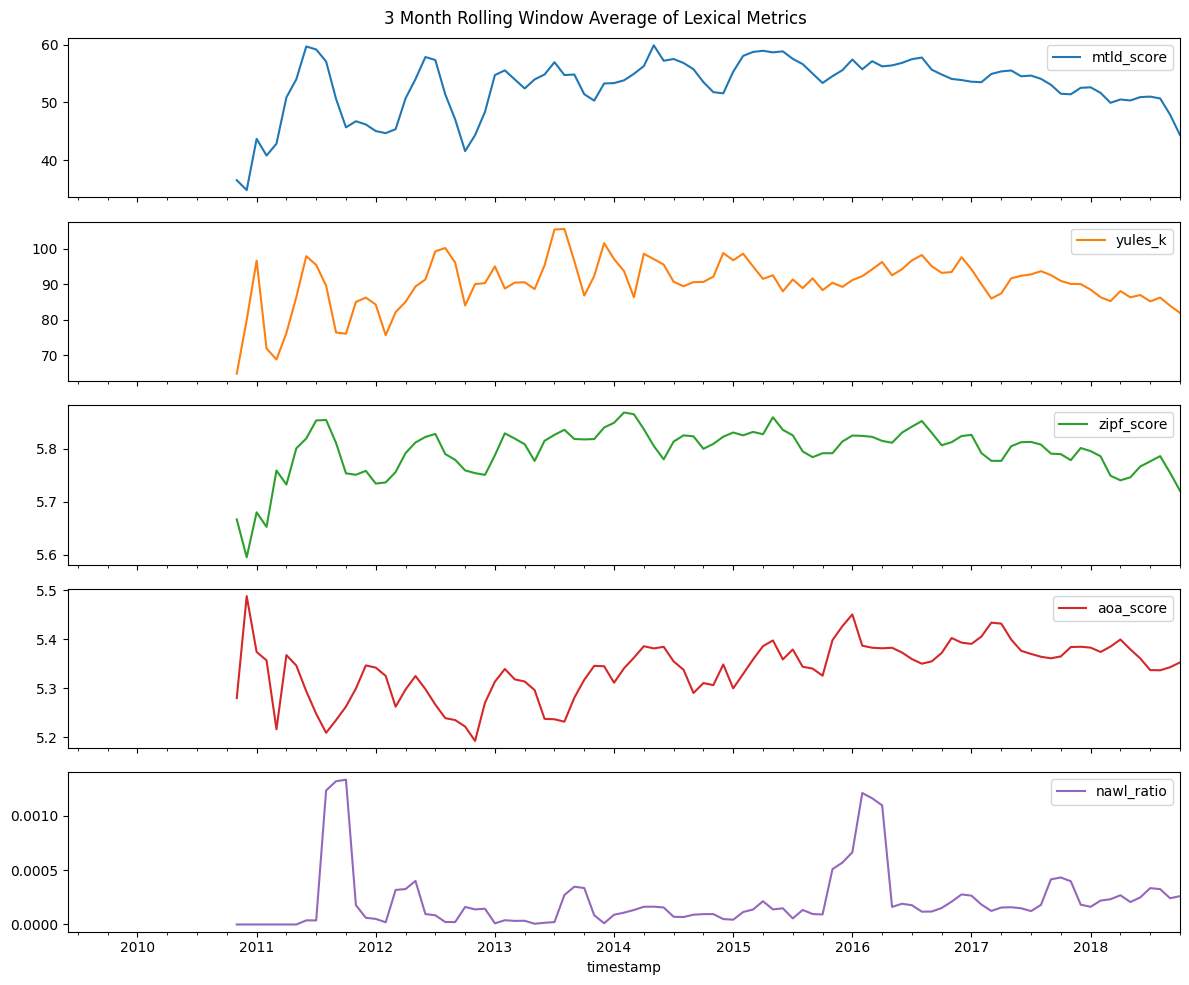

In [91]:
# smooth metrics for clear visualization by using quarterly rolling window
monthly_smooth = monthly_metrics[numeric_cols].rolling(3).mean()

# plot quarterly rolling window metrics
monthly_smooth.plot(
    subplots=True,
    figsize=(12, 10),
    layout=(5, 1),
    title="3 Month Rolling Window Average of Lexical Metrics",
    legend=True
)

plt.tight_layout()
plt.show()

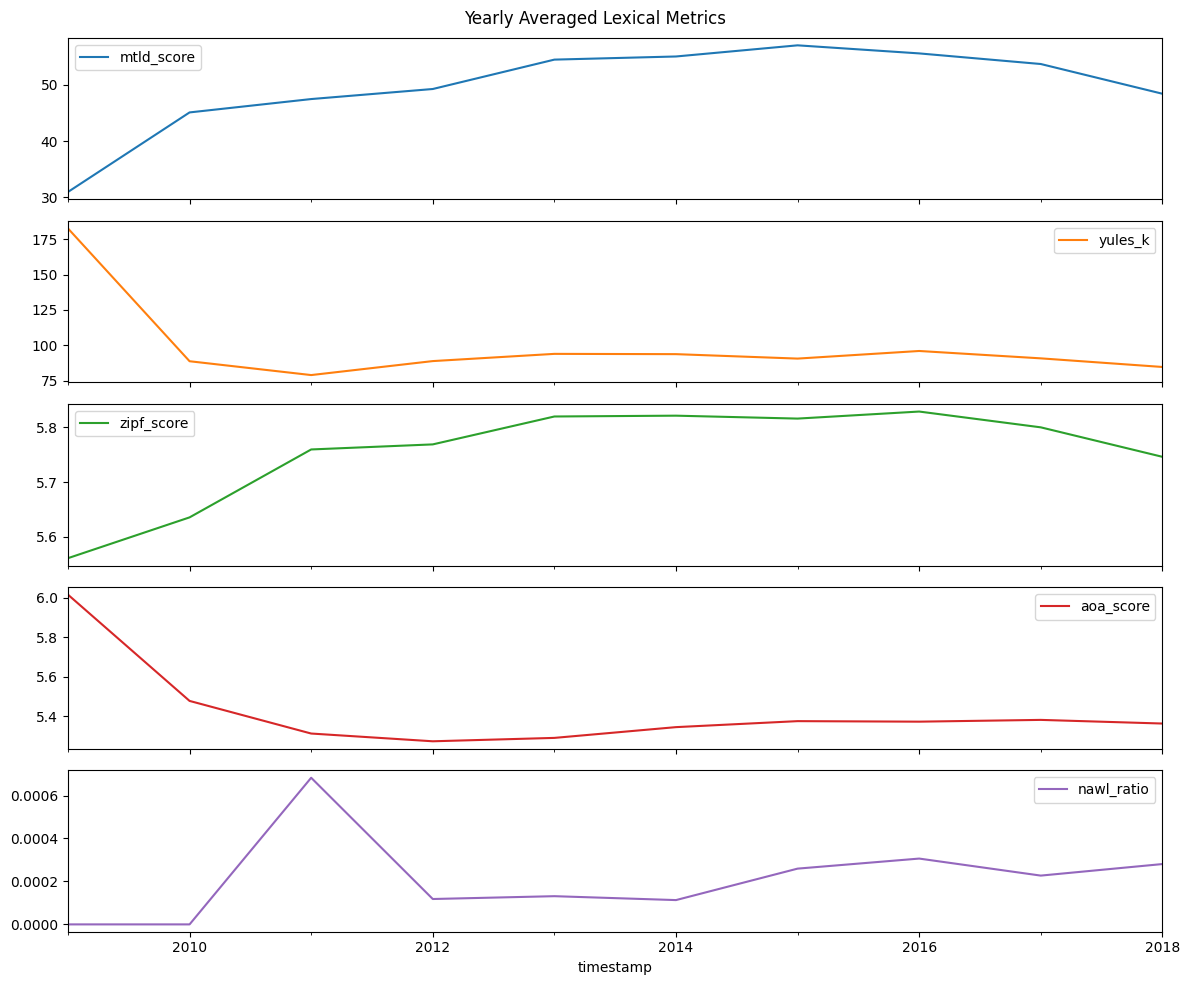

In [92]:
yearly_metrics = df[numeric_cols].resample("YE").mean()
yearly_metrics.plot(
    subplots=True,
    figsize=(12, 10),
    layout=(5, 1),
    title="Yearly Averaged Lexical Metrics",
    legend=True
)

plt.tight_layout()
plt.show()